<a href="https://colab.research.google.com/github/falvarezaguiar/PC5_Aprendizaje_Refuerzo_DQL_trading2/blob/main/PC5_entregar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Consolidación 5

**El código de este notebook es igual que el de Aprendizaje por Refuerzo aplicado a Trading que se explicó en clase.**

El objetivo ahora es extender este código para que tenga en cuenta lo siguiente:

- En el código de partida, el agente tiene dos acciones posibles cada día: comprar un paquete de acciones (buy) o vender un paquete de acciones (sell). En esta implementación, el reward total de la estrategia que sea "comprar siempre" es igual que el de una estrategia que sea "vender siempre": cero. Esto se debe a que los rewards en la implementación se calculan solo cuando se vende. Modifica el código para que cuando el agente llegue al final de la partida (**done=True**) se vendan todos los paquetes de acciones que tenga en su cartera (inventory) al precio de mercado en ese momento.

- Introduce un límite al tamaño de cartera (inventory) del agente, haciendo que este sea 5 (no puede tener más de 5 paquetes en su cartera). Por otra parte, amplía la información del estado S del agente para que incluya, además, el número de acciones que tiene en cartera (dividido entre 5, para que vaya entre 0 y 1). Para hacer esto último, modifica la definición de reset y step para que extiendan con este valor el array de salida que devuelven.

- Introduce una tercera acción que sea "Mantener", es decir, ni comprar ni vender. Cambia el esquema de rewards para dar un reward negativo al agente cuando intente vender, si la cartera (inventory) está vacía. Comprueba que efectivamente, una vez ha aprendido, el agente nunca trata de vender cuando su cartera está vacía.

**Introducción**
Este notebook está destinado a entender el Aprendizaje por Refuerzo con Redes Neuronales en vez de la Tabla Q.  Si sutituyen las Actions del agente (columnas en la tabla) por 3 neuronas de salida.  Los diferentes Estados son las entradas a la red neuronal (renglones de la tabla).  Esto se hacer por los diferentes son continuos.
El "juego" comprar/vender/mantener (las 3 acciones) un paquete de acciones, aprende de los diferentes estados (volviendo al pasado revisando la serie de tiempo-precios de venta de dicha acción), el retorno es Venta Positiva el castigo Venta Negativa y también tenemos otro castigo que es vender sin tener en inventary.
Para este ejercicio estamos limitando al Agente a tener máximo 5 acciones.

### Aprendizaje por refuerzo para trading

## Carga de librerias, crear carpetas

In [16]:
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import plot_model # Import plot_model

import numpy as np
import pandas as pd
import random
from collections import deque
import os

import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from tqdm import tqdm

In [3]:
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
urlretrieve("https://drive.google.com/uc?export=download&id=1u0BzRR6Sxv-2vUvwEuH-yKYjAFnTE0PC",
            "data/GSPC_2001-10.csv")
urlretrieve("https://drive.google.com/uc?export=download&id=1BPxsLWU6mBkZOpJ0hDYCqp4qj0_N2hjD",
            "data/GSPC_2011.csv");

## Carga y procesado de datos (limpieza)

In [4]:
df = pd.read_csv("data/GSPC_2001-10.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000
5,2001-01-09,1295.859985,1311.719971,1295.140015,1300.800049,1300.800049,1191300000
6,2001-01-10,1300.800049,1313.760010,1287.280029,1313.270020,1313.270020,1296500000
7,2001-01-11,1313.270020,1332.189941,1309.719971,1326.819946,1326.819946,1411200000
8,2001-01-12,1326.819946,1333.209961,1311.589966,1318.550049,1318.550049,1276000000
9,2001-01-16,1318.319946,1327.810059,1313.329956,1326.650024,1326.650024,1205700000


In [5]:
!ls data

GSPC_2001-10.csv  GSPC_2011.csv


In [6]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
    vec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()

    for line in lines[1:]:
        vec.append(float(line.split(",")[4])/1000)

    return vec

# returns an an n-day state representation ending at time t
# Estado: ventana que contiene la evolución de la serie financiera los últimos días
def getState(data, t, window_size):
    # primero genero un bloque de n+1 observaciones incluida el día actual:
    d = max(t-window_size, 0)
    block = data[d:t+1]
    l = len(block)
    if l<(window_size+1):
        block = (window_size+1 - l)*[data[0]] + block # padding con data[t0]

    # Rendimientos logarítmicos:
    res = np.log(np.divide(block[1:], block[:-1])) # log ( x(t) / x(t-1))
    # log(x(1)/x(0)) + log(x(2)/x(1)) + log(x(3)/x(2)) = log(x(3)/x(0))
    # ya que log(A) + log(B) = log(A*B)
    #
    return np.expand_dims(res, axis=0)

## Definición: Entorno, Reseteo de partida, Interacciones con entorno (buy / sell / hold), Reward Positivo y Negativo

* Acciones: 0=buy, 1=sell, 2=hold (tres acciones discretas).
* Límite de inventario: 5 paquetes (control de riesgo).
* Penalización al vender sin inventario: −0.01 (regulariza ventas inválidas).
* Liquidación al final del episodio: vende todo al precio actual (realiza PnL pendiente).
* Devuelve (next_state, reward, done) por step.

In [7]:
# para mí una partida en training es volver al 2 de enero de 2001 y hacer trading,
# día a día, hasta diciembre de 2010

class Env:
    def __init__(self, stock_name, window_size):
        self.data = getStockDataVec(stock_name) # leo datos de fichero
        self.final_t = len(self.data) - 1
        self.window_size = window_size
        self.reset()

    def reset(self):
        #self.state = getState(self.data, 0, window_size + 1)
        base_state = getState(self.data, 0, window_size)
        self.inventory = [] # lista de acciones compradas. Cada día solo puedo comprar 1. Esta lista contiene los precios de compra de cada acción
        # Paquete de acciones más antiguo: self.inventory[0]. El más reciente: self.inventory[-1]
        inv_ratio = len(self.inventory)/5
        self.state = np.concatenate([base_state, np.array([[inv_ratio]])], axis=1)
        self.t = 0
        return self.state

    def step(self, action):
        # This is how the agent will interact with the environment
        reward = 0
        if action==0: # buy
          if len(self.inventory) < 5:
              precio_hoy = self.data[self.t]
              self.inventory.append(precio_hoy) # añado a inventory precio actual de la acción financiera
              #print("Buy:", formatPrice(self.data[self.t]))

        elif action==1: # sell
            if len(self.inventory)>0:
                bought_price = self.inventory.pop(0) # elimino el paquete de acciones más antiguo
                precio_hoy = self.data[self.t]
                reward = precio_hoy - bought_price # diferencia entre precio actual y precio al que lo compré
                #print("Sell: {} | Profit: {}".format(formatPrice(self.data[self.t]),
                #                                     formatPrice(reward)))
            else:
                # Penalización por vender sin inventario.
                # Alternativa: escalarla a la variación típica, p.ej. -0.5*np.median(np.abs(np.diff(self.data)))
                reward = reward - 0.01

        elif action==2: # hold
            pass

        done = (self.t == self.final_t-1)
        # Liquidación de inventario al final del episodio
        if done and len(self.inventory) > 0:
            precio_hoy = self.data[self.t]
            reward += sum(precio_hoy - precio_compra for precio_compra in self.inventory)
            self.inventory.clear()

        # estado siguiente:
        #S_ = getState(self.data, self.t+1, self.window_size+1)
        S_base = getState(self.data, self.t+1, self.window_size)
        inv_ratio = len(self.inventory)/5
        S_ = np.concatenate([S_base, np.array([[inv_ratio]])], axis=1)
        self.state = S_
        self.t += 1
        return S_, reward, done

## Definición de Agente (peso pluma!), Selección de Acción, ExpReplay (hacer que la red recuerdo lo aprendido en el pasado). Determinar tamaño de cada cuánto y cómo recordar

* Política ε-greedy (exploración con prob. ε).
* Replay buffer deque(maxlen=memsize) y entrenamiento con train_on_batch sobre minibatches (rompe correlación temporal).
* Actualización de targets: r + γ·max_a' Q(s',a').

In [8]:
class Agent:
    def __init__(self, model, is_eval=False, gamma=0.95, epsilon_ini=1.,
                 epsilon_min=0.01, epsilon_decay=0.995, lr=0.001, memsize=1000):

        if type(model) == str:
            model = load_model(model)
        self.model = model
        self.state_size = self.model.input_shape[-1]
        self.action_size = self.model.output_shape[-1]
        self.memory = deque(maxlen=memsize)
        self.inventory = []
        self.is_eval = is_eval

        self.gamma = gamma
        self.epsilon = epsilon_ini
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state):
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        Qs = self.model.predict(state, verbose=0)[0]
        return np.argmax(Qs)

    def expReplay_no_optimo(self, batch_size):
        mini_batch = []
        L = len(self.memory)
        for i in range(L-batch_size+1, L):
            mini_batch.append(self.memory[i])

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])

            target_f = self.model.predict(state, state=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, wpochs=1, verbose=0)

    def get_batch(self, model, batch_size=10): # misma función anterior pero mucho más eficiente

        #How many experiences do we have?
        len_memory = len(self.memory)

        #We want to return an input and target vector with inputs from an observed state...
        inputs  = np.zeros((min(len_memory, batch_size), self.state_size))
        inputs2 = np.zeros(inputs.shape)

        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them

        actions = []
        rewards = []
        dones   = []

        #We draw states to learn from randomly:
        for i, idx in enumerate(np.random.randint(0, len_memory, size=len(inputs))):
            state, action, reward, next_state, done = self.memory[idx]
            inputs[i:(i+1)]  = state
            inputs2[i:(i+1)] = next_state
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

        targets = model.predict(inputs, verbose=0)
        max_next_Qs = np.max(model.predict(inputs2, verbose=0), axis=1)

        for i, (action, reward, done, Q_sa) in enumerate(zip(actions, rewards, dones, max_next_Qs)):
            if done:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.gamma*Q_sa

        return inputs, targets


    def expReplay(self, batch_size):
        inputs, targets = self.get_batch(self.model, batch_size=batch_size)

        # train model on experiences
        batch_loss = self.model.train_on_batch(inputs, targets)
        return batch_loss

#

Definimos la serie y acción que vamos a comprar (en este caso es el índice S&P500 del 2002) y fijamos en número de "juego" o partidas que vamos a permitir que juege el agente para aprender.

In [9]:
stock_name = "GSPC_2001-10"
episode_count = 100

Definimos arquitecura de la red neuronal, "sencillita"
* Sequential([Dense(10, relu), Dense(3)]) (3 Q-valores: buy/sell/hold).
* loss="mse", optimizer=Adam(lr=0.001).

In [10]:
# Red neuronal densa:

window_size = 10
model = Sequential()
model.add(Dense(units=10, input_dim=window_size+1, activation="relu"))
model.add(Dense(3))
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153 (612.00 B)

 Trainable params: 153 (612.00 B)

 Non-trainable params: 0 (0.00 B)

## Hyperparámetros principales

Tenemos una ventana de 10, que son los días o estados que revisamos con la función log  +  la nueva variable que es el ratio de 0 a 1 para el nivel de inventario que tenemos (empty - full)

Rendimientos logarítmicos (window_size valores): [log(x_t/x_{t-1}), log(x_{t-1}/x_{t-2}), ..., log(x_{t-window_size+1}/x_{t-window_size})].
Ratio de inventario (1 valor): len(self.inventory)/5 en [0, 1].

Con window_size = 10, son 11 variables de entrada en total

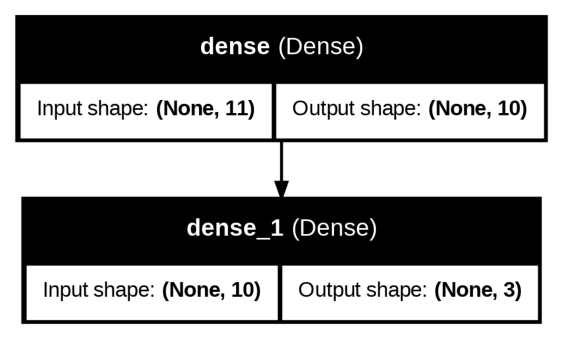

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="img.png")
plt.figure(figsize=(7,7))
plt.imshow(plt.imread("img.png"), aspect="equal"); plt.xticks([]); plt.yticks([]); plt.axis("off");

**Parámetros para maximizar aprendizaje**
*   ***Cuanto queremos que aprenda de experiencias pasadas*** memsize: tamaño del Replay Buffer. Más grande = experiencias más variadas y menos correladas, pero menos “recientes” y más lento. Training ratio = 64 cada cuantas épocas mete datos del pasado para entrenar. Más grande mayor estabilidad temporal
*   ***Cuánto de exploratorador*** queremos que sea el Agente "peso pluma" epsilon_ini / epsilon_decay / epsilon_min (por defecto=0.01): agenda de exploración ε-greedy. Tras cada episodio: ε ← ε·epsilon_decay. Con 0.95 y 20 episodios, ε≈0.36 (no llega a 0.01). Para llegar a 0.01 con 0.95 necesitas ≈90 episodios. Ajusta episodios o usa un decay más agresivo (p.ej. 0.93–0.97 según episodios).
*   ***Cuánto importancia le da el agente a los premios***, si es "previsor" o si quiere ganancias "inmediatas"; gamma (por defecto=0.95): descuento. 0.90-0.99 vayor valora más recompensas futuras.
*   learning rate por defecto 0.0001 lo dejaremos como está
*   batcc_size = 32... 128, son las muestreasdas de lbuffe en cada actualización de la red. Pequeño aprende rápido pero ruidoso; grande más estable pero puede "promediar" demasiado y requerir más pasos

*   enviroment = Env(stock_name, window_size)  window_size longitud de la ventana de retornos que entra al estado. Afecta a la dimensión de entrada y la capacidad de "contexto" temporal. Rango de 5-30
*   ***epsilon_decay*** determina cuánta exploración queda al **final**





In [18]:
agent = Agent(model, memsize=1000, epsilon_ini=1, epsilon_decay=0.95)
#batch_size = 32
#batch_size = 1024
batch_size = 128 # con cuántas experiencias de las 1000 que tiene la memoria reentreno la red
training_ratio = 64
environment = Env(stock_name, window_size)

## Entrenamiento + monitorización

Entrenamos por episodios (partidas)
* cada incio de partida (Reset), Env ejectua política, acumula profit y eperiencias, entrena según training_ratio
* Decaimiento de epsilon al final de cada episodio
* Métricas: Lista de profit_historico, eps_historico y invalid_sells por episodio
* Grafica: Profit por epsodio y Epsilon por episodio
* Print del total de ventas inválidas
* Guardamos al final de las partidas un único modelo

In [ ]:
# NUEVA CELDA: Monitorización de aprendizaje
# Curvas por episodio (profit, epsilon) + print de ventas inválidas (sell sin inventario).

# Cumple RulesNotebookColab: no nuevos imports, ≤100 líneas, explicación al final.

eps_hist = []
profit_hist = []
avg_loss_hist = []  # opcional: estabilidad
invalid_sells_hist = []

for e in range(episode_count + 1):
    total_profit = 0.0
    state = environment.reset()
    done = False
    counter = 0
    step_losses = []
    invalid_sells = 0

    while not done:
        action = agent.choose_action(state)
        # contar intentos de vender sin inventario
        if action == 1 and len(environment.inventory) == 0:
            invalid_sells += 1
        next_state, reward, done = environment.step(action)
        total_profit += float(reward)
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        counter += 1
        if (len(agent.memory) > batch_size) and ((counter % training_ratio) == 0):
            batch_loss = agent.expReplay(batch_size)
            try:
                step_losses.append(float(batch_loss))
            except Exception:
                pass

    # decay de epsilon por episodio
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # métricas por episodio
    eps_hist.append(float(agent.epsilon))
    profit_hist.append(total_profit)
    avg_loss_hist.append(np.mean(step_losses) if step_losses else np.nan)
    invalid_sells_hist.append(invalid_sells)

    print(f"Ep {e}/{episode_count} | Profit={total_profit:.2f} | eps={agent.epsilon:.3f} | invalid_sells={invalid_sells}")

# curvas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(profit_hist)
axes[0].axhline(0.0, color='k', linestyle='--', linewidth=0.8)
axes[0].set_title("Profit por episodio")
axes[0].set_xlabel("Episodio")
axes[0].set_ylabel("Profit")

axes[1].plot(eps_hist)
axes[1].axhline(getattr(agent, "epsilon_min", 0.01), color='r', linestyle='--', linewidth=0.8)
axes[1].set_title("Epsilon por episodio")
axes[1].set_xlabel("Episodio")

plt.tight_layout(); plt.show()

print("Total intentos de venta sin inventario:", int(np.nansum(invalid_sells_hist)))

# Save only the last model checkpoint
agent.model.save("models/last_model.keras")

# EXPLAIN: Reejecuta el entrenamiento con instrumentación para graficar profit/ε por episodio y
# reporta ventas inválidas por episodio y total; sin nuevas dependencias.

Ep 0/100 | Profit=-2.95 | eps=0.950 | invalid_sells=185
Ep 1/100 | Profit=-0.46 | eps=0.902 | invalid_sells=104
Ep 2/100 | Profit=-1.03 | eps=0.857 | invalid_sells=63
Ep 3/100 | Profit=-1.06 | eps=0.815 | invalid_sells=27
Ep 4/100 | Profit=0.43 | eps=0.774 | invalid_sells=22
Ep 5/100 | Profit=-1.75 | eps=0.735 | invalid_sells=25
Ep 6/100 | Profit=-0.96 | eps=0.698 | invalid_sells=14
Ep 7/100 | Profit=-1.40 | eps=0.663 | invalid_sells=23
Ep 8/100 | Profit=0.52 | eps=0.630 | invalid_sells=5
Ep 9/100 | Profit=0.47 | eps=0.599 | invalid_sells=0


Graficamos el profit_historico con un Moving Avg

In [ ]:
# NUEVA CELDA: Suavizado de profit (media móvil)
# Añade serie suavizada para facilitar lectura de tendencia de aprendizaje.

# ventana de suavizado
ma_window = 3

# MOD: usar variable existente si no se ejecutó la celda de monitorización
try:
    profits = profit_hist  # creado por la celda de monitorización
except NameError:
    profits = profits  # fallback a la lista original del notebook

# cálculo simple de media móvil sin dependencias adicionales
profit_ma = []
acc = 0.0
cnt = 0
for i, v in enumerate(profits):
    acc += float(v)
    cnt += 1
    # usar ventana deslizante manualmente
    if i+1 < ma_window:
        profit_ma.append(acc / cnt)
    else:
        # restar elemento que sale de la ventana
        acc_window = sum(float(profits[j]) for j in range(i-ma_window+1, i+1))
        profit_ma.append(acc_window / ma_window)

plt.figure(figsize=(8, 3))
plt.plot(profits, label="Profit")
plt.plot(profit_ma, label=f"Profit (MA{ma_window})", linewidth=2)
plt.axhline(0.0, color='k', linestyle='--', linewidth=0.8)
plt.title("Profit por episodio (con suavizado)")
plt.xlabel("Episodio")
plt.ylabel("Profit")
plt.legend(); plt.tight_layout(); plt.show()

# EXPLAIN: Se usa profit_hist si existe; si no, profits del notebook.
# Media móvil configurable (por defecto=3); sin nuevas dependencias.


### Evaluación

Carga del checkpoint exacto last_model_path

In [ ]:
!ls -la models/model_ep

Dataset de test el resto de la serie (out-of-sample)

In [ ]:
# REN: model_name->last_model_path
last_model_path = 'models/last_model.keras'  # único checkpoint persistido
#stock_name = 'GSPC_2001-10'
stock_name = 'GSPC_2011'

Agente "peso pluma" a tome, nada de exploración, tomando decisiones contundentes, en ***modo exPLOTAción***


In [ ]:
agent = Agent(model=last_model_path, is_eval=True)
environment = Env(stock_name, window_size)
state = environment.reset()
state

In [ ]:
serie   = []
actions = []

Juega esas partidas NO VISTAS y vamos evaluando su "rendimiento" (cuanto gana) y si hace alguna acción incorrecta (intento de vender sin tener inventory)
Nos dal el Profit total de esta serie de TEST

In [ ]:
done = False
total_profit = 0
invalid_sells = 0
while not done:
    action = agent.choose_action(state)
    # contar intentos de vender sin inventario
    if action == 1 and len(environment.inventory) == 0:
        invalid_sells += 1

    # Check if environment.t is within the bounds of environment.data
    if environment.t < len(environment.data):
        serie.append(environment.data[environment.t])
        actions.append(action)
    else:
        # Handle the case where environment.t is out of bounds, maybe break the loop or log a warning
        print(f"Warning: environment.t ({environment.t}) is out of bounds for environment.data (length {len(environment.data)})")
        break


    next_state, reward, done = environment.step(action)
    total_profit += reward

    state = next_state

print("--------------------------------")
print(stock_name + " Total Profit: " + formatPrice(total_profit))
print("Venders sin inventario (intentos):", invalid_sells)
print("--------------------------------")

Solo como recordatorio, con el anterior agente obtuvimos un Profit de 0.43  durante casi 3 años de invertir.

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(serie)
aux1 = np.array(serie)
aux2 = np.array(actions)

inds = np.where(aux2==0)[0]
plt.plot(inds, aux1[inds], 'og', label="buy")
inds = np.where(aux2==1)[0]
plt.plot(inds, aux1[inds], 'or', label="sell")
inds = np.where(aux2==2)[0]
plt.plot(inds, aux1[inds], 'ob', label="hold")
plt.legend();

A contiuanción tenemos los resultados del anterior Agente (era peso pluma solo tenía dos punch buy/sell, sin gancho!):
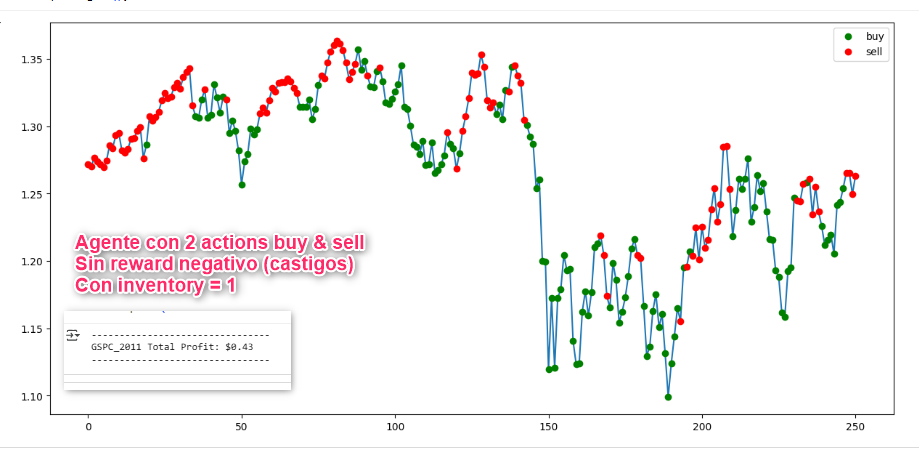

El parecido de las gráficas es sorprendente.
Moraleja, si inviertes en bolsa, tienes que ver el largo plazo, los fundamentales de la empresa en la que inviertas y a ser posible buscar empresas que den dividentos.  Posiblemente si el entorno tomara más estados en cuenta, podría mejorar un poco el profit.

Como resumen de lo aprendido en este notebook tenemos:
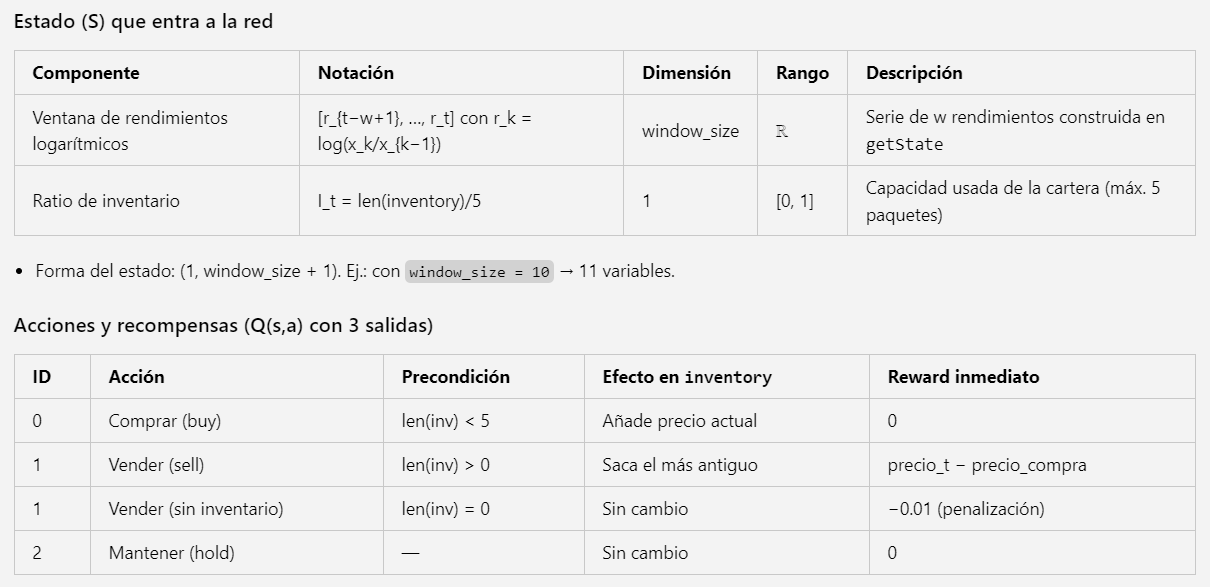




*   Paso termina: si done = True, se liquidan todas las posiciones restantes al precio precio_t y se suma su ganancia/pérdida al reward final
*   La red neuronal remplaza la "tabla Q":  estima Q(s,a) para actiones de buy,sell,hold y se elige armax

Además los resultados son muy similares.
Tal vez lo que tocaría es estudiar, más factores del Entorno que puedan ser interesantes.
Existe otro Notebook que lo hace con resultados un poquito similares.


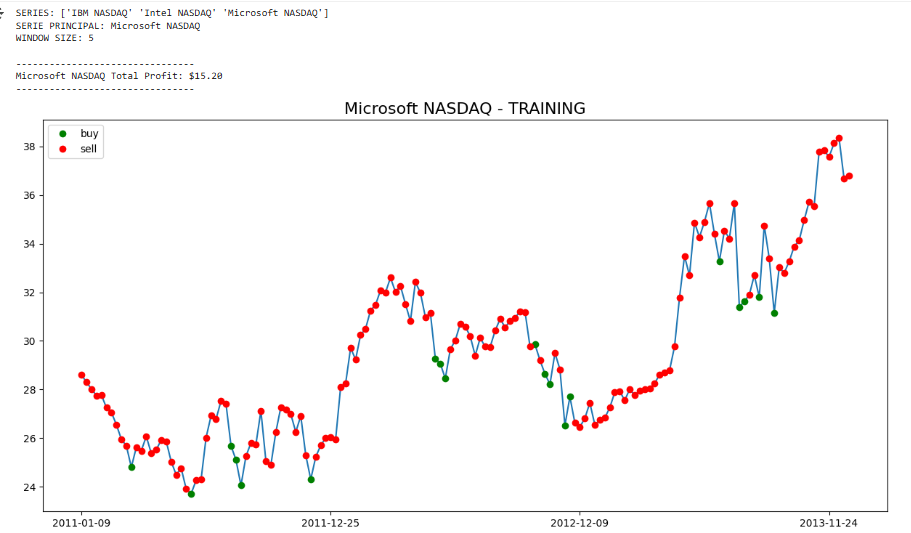

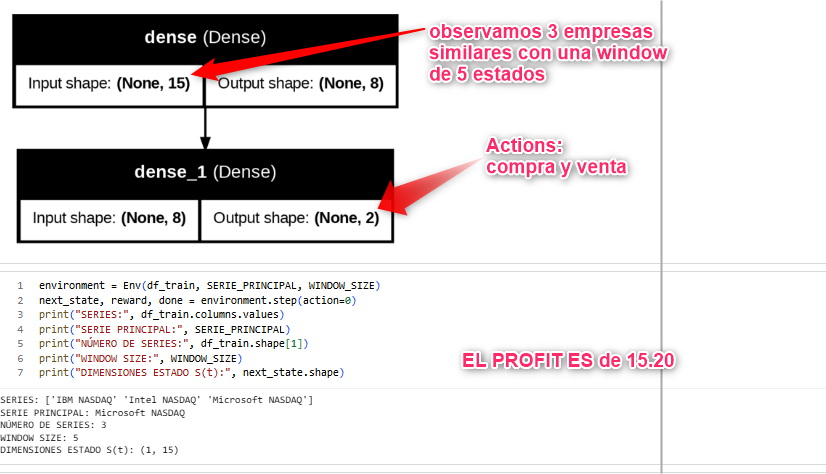

EOF